In [1]:
# Run in python console
import nltk

### 预处理

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords

In [4]:
df = pd.read_excel("C:/Users/onrik\\report\\0203_LDA\\조선일보 가공.xlsx")
df.head()

,title,url,date,분류,content
0,"경찰, 로톡 변호사법 위반 불송치… “혐의 없다”",https://biz.chosun.com/topics/topics_social/20...,2021.12.31,https://biz,경찰이 변호사법 위반 등 혐의로 고발된 온라인 법률상담 플랫폼 ‘로톡’ 운영사를 불...
1,교회도 빅데이터로 맞춤형 선교…종교 디지털 전환 시작되나,https://biz.chosun.com/international/internati...,2021.12.27,https://biz,"미국의 빅데이터 분석 회사와 지역 교회들이 협업해 신도 모집, 봉사활동 전략을 세우..."
2,"“1인가구는 대학가, 4인가구는 강남·서초에서 배달앱 많이 써”",https://biz.chosun.com/topics/topics_social/20...,2021.12.22,https://biz,가구원수에 따라 배달앱 사용이 많은 지역이 다른 것으로 나타났다. 1인가구의 배달앱...
3,"휴대용 엑스레이, 블록체인 기반 신원증명… 규제 벗고 ‘성장 날개’ 달아",https://www.chosun.com/economy/industry-compan...,2021.12.22,https://www,중소벤처기업부는 2019년 1차 특구 지정 후 총 29개 규제자유특구를 지정하고 일...
4,“빅테크 단속에 中 앱시장 3년간 38% 축소…고성장 시대 끝났다”,https://biz.chosun.com/international/internati...,2021.12.21,https://biz,중국 당국이 빅테크 규제를 강화하면서 지난 3년간 중국 앱 시장 규모가 40% 가까...


In [5]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

df['content가공2'] = ''
for i in range(len(df)):
    df.at[i,'content가공2'] = ' '.join(x for x in data_words[i])
df

,title,url,date,분류,content,content가공2
0,"경찰, 로톡 변호사법 위반 불송치… “혐의 없다”",https://biz.chosun.com/topics/topics_social/20...,2021.12.31,https://biz,경찰이 변호사법 위반 등 혐의로 고발된 온라인 법률상담 플랫폼 ‘로톡’ 운영사를 불...,경찰이 변호사법 위반 혐의로 고발된 온라인 법률상담 플랫폼 로톡 운영사를 불송치했다...
1,교회도 빅데이터로 맞춤형 선교…종교 디지털 전환 시작되나,https://biz.chosun.com/international/internati...,2021.12.27,https://biz,"미국의 빅데이터 분석 회사와 지역 교회들이 협업해 신도 모집, 봉사활동 전략을 세우...",미국의 빅데이터 분석 회사와 지역 교회들이 협업해 신도 모집 봉사활동 전략을 세우는...
2,"“1인가구는 대학가, 4인가구는 강남·서초에서 배달앱 많이 써”",https://biz.chosun.com/topics/topics_social/20...,2021.12.22,https://biz,가구원수에 따라 배달앱 사용이 많은 지역이 다른 것으로 나타났다. 1인가구의 배달앱...,가구원수에 따라 배달앱 사용이 많은 지역이 다른 것으로 나타났다 인가구의 배달앱 사...
3,"휴대용 엑스레이, 블록체인 기반 신원증명… 규제 벗고 ‘성장 날개’ 달아",https://www.chosun.com/economy/industry-compan...,2021.12.22,https://www,중소벤처기업부는 2019년 1차 특구 지정 후 총 29개 규제자유특구를 지정하고 일...,중소벤처기업부는 특구 지정 규제자유특구를 지정하고 일자리 창출 투자 유치와 같은 활...
4,“빅테크 단속에 中 앱시장 3년간 38% 축소…고성장 시대 끝났다”,https://biz.chosun.com/international/internati...,2021.12.21,https://biz,중국 당국이 빅테크 규제를 강화하면서 지난 3년간 중국 앱 시장 규모가 40% 가까...,중국 당국이 빅테크 규제를 강화하면서 지난 년간 중국 시장 규모가 가까이 줄었다고 ...
...,...,...,...,...,...,...
200,"유학생 40명 ‘한눈에 반한’ 고대 교직원, 처벌 못한다는데",http://news.chosun.com/misaeng/site/data/html_...,2020.03.27,http://news,"‘사진을 봤는데 예뻐서 연락했다’, ‘한눈에 반했다’, ‘친해지고 싶다.’고려대 국...",사진을 봤는데 예뻐서 연락했다 한눈에 반했다 친해지고 싶다 고려대 국제처 글로벌센터...
201,"“가명정보 처리, 상업 목적 활용도 당연히 포함”",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.18,https://biz,정보 주체의 동의없이도 개인정보 활용을 가능하도록 한 ‘데이터 3법’이 최근 국회를...,정보 주체의 동의없이도 개인정보 활용을 가능하도록 데이터 최근 국회를 통과했지만 아...
202,"해외기업 개인정보 침해… 정부, 외국 기관과 공조 강화",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.17,https://biz,"대통령소속 개인정보보호위원회는 페이스북, 구글 등 글로벌 대기업의 개인정보 침해 사...",대통령소속 개인정보보호위원회는 페이스북 구글 글로벌 대기업의 개인정보 침해 사고에 ...
203,"금감원의 반격, 우리銀 비번 도용 제재심 올린다",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.09,https://biz,우리은행 영업점 직원이 고객의 휴면계좌 2만3000여개의 인터넷·모바일뱅킹 비밀번호...,우리은행 영업점 직원이 고객의 휴면계좌 여개의 인터넷 모바일뱅킹 비밀번호를 무단 변...


In [6]:
from konlpy.tag import Okt
okt = Okt()
cols = ['content가공2']
for i in range(len(df)):
    for col in cols:
        content_all = df.loc[i,col]
        morphs_txt = okt.pos(content_all,stem=True)
        df.at[i,col] = morphs_txt

resultdf = df
resultdf

,title,url,date,분류,content,content가공2
0,"경찰, 로톡 변호사법 위반 불송치… “혐의 없다”",https://biz.chosun.com/topics/topics_social/20...,2021.12.31,https://biz,경찰이 변호사법 위반 등 혐의로 고발된 온라인 법률상담 플랫폼 ‘로톡’ 운영사를 불...,"[(경찰, Noun), (이, Josa), (변호, Noun), (사법, Noun)..."
1,교회도 빅데이터로 맞춤형 선교…종교 디지털 전환 시작되나,https://biz.chosun.com/international/internati...,2021.12.27,https://biz,"미국의 빅데이터 분석 회사와 지역 교회들이 협업해 신도 모집, 봉사활동 전략을 세우...","[(미국, Noun), (의, Josa), (빅데이터, Noun), (분석, Nou..."
2,"“1인가구는 대학가, 4인가구는 강남·서초에서 배달앱 많이 써”",https://biz.chosun.com/topics/topics_social/20...,2021.12.22,https://biz,가구원수에 따라 배달앱 사용이 많은 지역이 다른 것으로 나타났다. 1인가구의 배달앱...,"[(가구, Noun), (원수, Noun), (에, Josa), (따르다, Verb..."
3,"휴대용 엑스레이, 블록체인 기반 신원증명… 규제 벗고 ‘성장 날개’ 달아",https://www.chosun.com/economy/industry-compan...,2021.12.22,https://www,중소벤처기업부는 2019년 1차 특구 지정 후 총 29개 규제자유특구를 지정하고 일...,"[(중소, Noun), (벤처기업, Noun), (불다, Verb), (특구, No..."
4,“빅테크 단속에 中 앱시장 3년간 38% 축소…고성장 시대 끝났다”,https://biz.chosun.com/international/internati...,2021.12.21,https://biz,중국 당국이 빅테크 규제를 강화하면서 지난 3년간 중국 앱 시장 규모가 40% 가까...,"[(중국, Noun), (당국, Noun), (이, Josa), (빅, Noun),..."
...,...,...,...,...,...,...
200,"유학생 40명 ‘한눈에 반한’ 고대 교직원, 처벌 못한다는데",http://news.chosun.com/misaeng/site/data/html_...,2020.03.27,http://news,"‘사진을 봤는데 예뻐서 연락했다’, ‘한눈에 반했다’, ‘친해지고 싶다.’고려대 국...","[(사진, Noun), (을, Josa), (보다, Verb), (예쁘다, Adje..."
201,"“가명정보 처리, 상업 목적 활용도 당연히 포함”",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.18,https://biz,정보 주체의 동의없이도 개인정보 활용을 가능하도록 한 ‘데이터 3법’이 최근 국회를...,"[(정보, Noun), (주체, Noun), (의, Josa), (동의, Noun)..."
202,"해외기업 개인정보 침해… 정부, 외국 기관과 공조 강화",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.17,https://biz,"대통령소속 개인정보보호위원회는 페이스북, 구글 등 글로벌 대기업의 개인정보 침해 사...","[(대통령, Noun), (소속, Noun), (개인, Noun), (정보보호, N..."
203,"금감원의 반격, 우리銀 비번 도용 제재심 올린다",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.09,https://biz,우리은행 영업점 직원이 고객의 휴면계좌 2만3000여개의 인터넷·모바일뱅킹 비밀번호...,"[(우리은행, Noun), (영업, Noun), (점, Noun), (직원, Nou..."


In [7]:
for i in range(len(resultdf)):
    for col in cols:
        lls = []
        if len(resultdf.loc[i,col]) == 0:
            pass
        else:
            for j in range(len(resultdf.loc[i,col])):
                if resultdf.loc[i,col][j][1] in ['Noun','Hashtag','Adjective']:
                    if resultdf.loc[i,col][j][1] == 'Hashtag':
                        lls.append((resultdf.loc[i,col][j][0].split('#')[-1],resultdf.loc[i,col][j][1]))
                    else:
                        lls.append(resultdf.loc[i,col][j])
            resultdf.at[i,col] = lls
resultdf

,title,url,date,분류,content,content가공2
0,"경찰, 로톡 변호사법 위반 불송치… “혐의 없다”",https://biz.chosun.com/topics/topics_social/20...,2021.12.31,https://biz,경찰이 변호사법 위반 등 혐의로 고발된 온라인 법률상담 플랫폼 ‘로톡’ 운영사를 불...,"[(경찰, Noun), (변호, Noun), (사법, Noun), (위반, Noun..."
1,교회도 빅데이터로 맞춤형 선교…종교 디지털 전환 시작되나,https://biz.chosun.com/international/internati...,2021.12.27,https://biz,"미국의 빅데이터 분석 회사와 지역 교회들이 협업해 신도 모집, 봉사활동 전략을 세우...","[(미국, Noun), (빅데이터, Noun), (분석, Noun), (회사, No..."
2,"“1인가구는 대학가, 4인가구는 강남·서초에서 배달앱 많이 써”",https://biz.chosun.com/topics/topics_social/20...,2021.12.22,https://biz,가구원수에 따라 배달앱 사용이 많은 지역이 다른 것으로 나타났다. 1인가구의 배달앱...,"[(가구, Noun), (원수, Noun), (배달, Noun), (앱, Noun)..."
3,"휴대용 엑스레이, 블록체인 기반 신원증명… 규제 벗고 ‘성장 날개’ 달아",https://www.chosun.com/economy/industry-compan...,2021.12.22,https://www,중소벤처기업부는 2019년 1차 특구 지정 후 총 29개 규제자유특구를 지정하고 일...,"[(중소, Noun), (벤처기업, Noun), (특구, Noun), (지정, No..."
4,“빅테크 단속에 中 앱시장 3년간 38% 축소…고성장 시대 끝났다”,https://biz.chosun.com/international/internati...,2021.12.21,https://biz,중국 당국이 빅테크 규제를 강화하면서 지난 3년간 중국 앱 시장 규모가 40% 가까...,"[(중국, Noun), (당국, Noun), (빅, Noun), (테크, Noun)..."
...,...,...,...,...,...,...
200,"유학생 40명 ‘한눈에 반한’ 고대 교직원, 처벌 못한다는데",http://news.chosun.com/misaeng/site/data/html_...,2020.03.27,http://news,"‘사진을 봤는데 예뻐서 연락했다’, ‘한눈에 반했다’, ‘친해지고 싶다.’고려대 국...","[(사진, Noun), (예쁘다, Adjective), (연락, Noun), (한눈..."
201,"“가명정보 처리, 상업 목적 활용도 당연히 포함”",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.18,https://biz,정보 주체의 동의없이도 개인정보 활용을 가능하도록 한 ‘데이터 3법’이 최근 국회를...,"[(정보, Noun), (주체, Noun), (동의, Noun), (없다, Adje..."
202,"해외기업 개인정보 침해… 정부, 외국 기관과 공조 강화",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.17,https://biz,"대통령소속 개인정보보호위원회는 페이스북, 구글 등 글로벌 대기업의 개인정보 침해 사...","[(대통령, Noun), (소속, Noun), (개인, Noun), (정보보호, N..."
203,"금감원의 반격, 우리銀 비번 도용 제재심 올린다",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.09,https://biz,우리은행 영업점 직원이 고객의 휴면계좌 2만3000여개의 인터넷·모바일뱅킹 비밀번호...,"[(우리은행, Noun), (영업, Noun), (점, Noun), (직원, Nou..."


In [8]:
k_stopword = pd.read_csv("korean_stopword_0317.csv")
k_stopword = list(k_stopword['불용어'])
for i in range(len(resultdf)):
    for col in cols:
        newlst = []
        for word in resultdf.loc[i,col]:
            if word[0] not in k_stopword:
                newlst.append(word)
        resultdf.at[i,col] = newlst
ldadf = resultdf

In [9]:
for col in cols:
    resultdf[col + 'bigram'] = ''

for i in range(len(resultdf)):
    for col in cols:
        newlst = resultdf.loc[i,col]
        if len(newlst) == 0 or len(newlst) == 1:
            pass
        else:
            bigram = [newlst[0][0] + '_' + newlst[1][0]]
            if len(newlst) == 2:
                resultdf.at[i,col+'bigram'] = bigram
            else:
                for j in range(2,len(newlst)):
                    biword = newlst[j-1][0] + '_' + newlst[j][0]
                    triword = newlst[j-2][0] + '_' + newlst[j-1][0] + '_' + newlst[j][0]
                    bigram.append(biword)
                resultdf.at[i,col+'bigram'] = bigram
resultdf

,title,url,date,분류,content,content가공2,content가공2bigram
0,"경찰, 로톡 변호사법 위반 불송치… “혐의 없다”",https://biz.chosun.com/topics/topics_social/20...,2021.12.31,https://biz,경찰이 변호사법 위반 등 혐의로 고발된 온라인 법률상담 플랫폼 ‘로톡’ 운영사를 불...,"[(경찰, Noun), (변호, Noun), (사법, Noun), (위반, Noun...","[경찰_변호, 변호_사법, 사법_위반, 위반_혐의, 혐의_고발, 고발_온라인, 온라..."
1,교회도 빅데이터로 맞춤형 선교…종교 디지털 전환 시작되나,https://biz.chosun.com/international/internati...,2021.12.27,https://biz,"미국의 빅데이터 분석 회사와 지역 교회들이 협업해 신도 모집, 봉사활동 전략을 세우...","[(미국, Noun), (빅데이터, Noun), (분석, Noun), (회사, No...","[미국_빅데이터, 빅데이터_분석, 분석_회사, 회사_지역, 지역_교회, 교회_협업,..."
2,"“1인가구는 대학가, 4인가구는 강남·서초에서 배달앱 많이 써”",https://biz.chosun.com/topics/topics_social/20...,2021.12.22,https://biz,가구원수에 따라 배달앱 사용이 많은 지역이 다른 것으로 나타났다. 1인가구의 배달앱...,"[(가구, Noun), (원수, Noun), (배달, Noun), (앱, Noun)...","[가구_원수, 원수_배달, 배달_앱, 앱_사용, 사용_지역, 지역_인, 인_가구, ..."
3,"휴대용 엑스레이, 블록체인 기반 신원증명… 규제 벗고 ‘성장 날개’ 달아",https://www.chosun.com/economy/industry-compan...,2021.12.22,https://www,중소벤처기업부는 2019년 1차 특구 지정 후 총 29개 규제자유특구를 지정하고 일...,"[(중소, Noun), (벤처기업, Noun), (특구, Noun), (지정, No...","[중소_벤처기업, 벤처기업_특구, 특구_지정, 지정_규제, 규제_자유, 자유_특, ..."
4,“빅테크 단속에 中 앱시장 3년간 38% 축소…고성장 시대 끝났다”,https://biz.chosun.com/international/internati...,2021.12.21,https://biz,중국 당국이 빅테크 규제를 강화하면서 지난 3년간 중국 앱 시장 규모가 40% 가까...,"[(중국, Noun), (당국, Noun), (빅, Noun), (테크, Noun)...","[중국_당국, 당국_빅, 빅_테크, 테크_규제, 규제_강화하다, 강화하다_중국, 중..."
...,...,...,...,...,...,...,...
200,"유학생 40명 ‘한눈에 반한’ 고대 교직원, 처벌 못한다는데",http://news.chosun.com/misaeng/site/data/html_...,2020.03.27,http://news,"‘사진을 봤는데 예뻐서 연락했다’, ‘한눈에 반했다’, ‘친해지고 싶다.’고려대 국...","[(사진, Noun), (예쁘다, Adjective), (연락, Noun), (한눈...","[사진_예쁘다, 예쁘다_연락, 연락_한눈, 한눈_반하다, 반하다_고려대, 고려대_국..."
201,"“가명정보 처리, 상업 목적 활용도 당연히 포함”",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.18,https://biz,정보 주체의 동의없이도 개인정보 활용을 가능하도록 한 ‘데이터 3법’이 최근 국회를...,"[(정보, Noun), (주체, Noun), (동의, Noun), (개인정보, No...","[정보_주체, 주체_동의, 동의_개인정보, 개인정보_활용, 활용_데이터, 데이터_국..."
202,"해외기업 개인정보 침해… 정부, 외국 기관과 공조 강화",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.17,https://biz,"대통령소속 개인정보보호위원회는 페이스북, 구글 등 글로벌 대기업의 개인정보 침해 사...","[(대통령, Noun), (소속, Noun), (개인, Noun), (정보보호, N...","[대통령_소속, 소속_개인, 개인_정보보호, 정보보호_위원회, 위원회_페이스북, 페..."
203,"금감원의 반격, 우리銀 비번 도용 제재심 올린다",https://biz.chosun.com/site/data/html_dir/2020...,2020.02.09,https://biz,우리은행 영업점 직원이 고객의 휴면계좌 2만3000여개의 인터넷·모바일뱅킹 비밀번호...,"[(우리은행, Noun), (영업, Noun), (직원, Noun), (고객, No...","[우리은행_영업, 영업_직원, 직원_고객, 고객_휴면, 휴면_계좌, 계좌_여개, 여..."


In [10]:
gramlst = []
gramcol = ['content가공2', 'content가공2bigram']

for gram in gramcol:

    contents_all = []
    for i in range(len(resultdf)):
        contents_all += resultdf.loc[i,gram]
    gramlst.append({'column':gram+'_all','data': contents_all})
gramdf = pd.DataFrame(gramlst)

from collections import Counter
contents_all = []
for i in range(1,len(gramdf)):
    contents_all += gramdf.loc[i,'data']

ngram_count = Counter(contents_all)
rank_ngram = ngram_count.most_common()
rank_ngram = dict(rank_ngram)
count_len = 10
ngram_dic = {}
for key,value in rank_ngram.items():
    if value > count_len:
        ngram_dic[key] = value
rank_ngram = ngram_dic

ngram_dic = {}
for key,value in rank_ngram.items():
    ngram_dic[key] = value
list(ngram_dic.keys())

['마이_데이터',
 '개인정보보호법_위반',
 '신용_평가',
 '개인_정보보호',
 '위반_혐의',
 '데이터_사업',
 '개인_정보',
 '정보_주체',
 '개인정보_유출',
 '인공_지능',
 '데이터_활용',
 '빅_테크',
 '핀_테크',
 '가명_정보',
 '고발_사주',
 '신용정보_법',
 '개인정보_보호',
 '공수_처가',
 '체포_의안',
 '대안_신용',
 '개인정보_위',
 '시행_령',
 '정보보호_위원회',
 '스마트_시티',
 '국민_힘',
 '사주_의혹',
 '데이터_산업',
 '정보_제공',
 '데이터_사업자',
 '코_노미',
 '노미_조선',
 '법_위반',
 '판결_문',
 '서비스_제공',
 '판사_사찰',
 '정보_정책',
 '금융_데이터',
 '개인정보_처리',
 '디지털_뉴딜',
 '박사_방',
 '고위_공직자',
 '정보_활용',
 '데이터_법',
 '개인_데이터',
 '정책_관',
 '헬_스케',
 '처_검사',
 '정보_유출',
 '데이터_수집',
 '공직선거법_위반',
 '담당_관',
 '개인정보_수집',
 '법_개인정보보호법',
 '카카오_톡',
 '가명_처리',
 '법_개정안',
 '비_금융',
 '윤석열_검찰총장',
 '법무부_장관',
 '공직자_범죄수사',
 '범죄수사_처',
 '처_처',
 '처_고발',
 '데이터_기반',
 '법_세련',
 '금융_위원회',
 '과징금_부과',
 '범죄_단체',
 '중국_정부',
 '혐의_적용',
 '재판_부',
 '현지_시각',
 '데이터_결합',
 '권리_행사',
 '수사_정보',
 '대검_감찰',
 '금융_정보',
 '구속영장_청구',
 '금융_사',
 '네이버_파이',
 '데이터_개인정보보호법',
 '금융_당국',
 '복무_요원',
 '데이터_분석',
 '개인정보보호법_정보통신망법',
 '무상_비밀',
 '비밀_누설',
 '주체_동의',
 '행사_방해',
 '보호_법',
 '정치자금_법',
 '의원_체포',
 '주민_센터',
 '정보_수집',
 '특정_개인'

In [11]:
ngram_word = ['마이_데이터',
 '개인정보보호법_위반',
 '신용_평가',
 '개인_정보보호',
 '데이터_사업',
 '개인_정보',
 '정보_주체',
 '개인정보_유출',
 '인공_지능',
 '빅_테크',
 '핀_테크',
 '가명_정보',
 '신용정보_법',
 '개인정보_보호',
 '공수_처가',
 '시행_령',
 '정보보호_위원회',
 '스마트_시티',
 '국민_힘',
 '데이터_산업',
 '정보_제공',
 '데이터_사업자',
 '판결_문',
 '서비스_제공',
 '정보_정책',
 '금융_데이터',
 '개인정보_처리',
 '디지털_뉴딜',
 '박사_방',
 '고위_공직자',
 '데이터_법',
 '개인_데이터',
 '정책_관',
 '정보_활용',
 '공직선거법_위반',
 '담당_관',
 '개인정보_수집',
 '카카오_톡',
 '가명_처리',
 '법_개정안',
 '법무부_장관',
 '범죄수사_처',
 '데이터_기반',
 '금융_위원회',
 '범죄_단체',
 '중국_정부',
 '재판_부',
 '현지_시각',
 '데이터_결합',
 '권리_행사',
 '금융_정보',
 '금융_사',
 '금융_당국',
 '복무_요원',
 '데이터_분석',
 '개인정보보호법_정보통신망법',
 '보호_법',
 '주민_센터',
 '확_진자',
 '서비스_개발',
 '위치_정보',
 '정책_관실',
 '매출_액',
 '자율_주행',
 '개인정보_침해',
 '텔레_그램',
 '금융_거래',
 '블록_체인',
 '쿠팡_츠',
 '개인_정보처리',
 '한국_인터넷',
 '미래_통합',
 '중앙_검',
 '데이터_시장',
 '금융_보안',
 '개인정보보호법_신용정보',
 '데이터_거래소',
 '배달_파트너',
 '금융_서비스',
 '고객_정보',
 '개인정보보호법_개정',
 '주민등록_번호',
 '플랫폼_기업',
 '거래_정보',
 '테크_기업',
 '데이터_시행']
ngram_word

['마이_데이터',
 '개인정보보호법_위반',
 '신용_평가',
 '개인_정보보호',
 '데이터_사업',
 '개인_정보',
 '정보_주체',
 '개인정보_유출',
 '인공_지능',
 '빅_테크',
 '핀_테크',
 '가명_정보',
 '신용정보_법',
 '개인정보_보호',
 '공수_처가',
 '시행_령',
 '정보보호_위원회',
 '스마트_시티',
 '국민_힘',
 '데이터_산업',
 '정보_제공',
 '데이터_사업자',
 '판결_문',
 '서비스_제공',
 '정보_정책',
 '금융_데이터',
 '개인정보_처리',
 '디지털_뉴딜',
 '박사_방',
 '고위_공직자',
 '데이터_법',
 '개인_데이터',
 '정책_관',
 '정보_활용',
 '공직선거법_위반',
 '담당_관',
 '개인정보_수집',
 '카카오_톡',
 '가명_처리',
 '법_개정안',
 '법무부_장관',
 '범죄수사_처',
 '데이터_기반',
 '금융_위원회',
 '범죄_단체',
 '중국_정부',
 '재판_부',
 '현지_시각',
 '데이터_결합',
 '권리_행사',
 '금융_정보',
 '금융_사',
 '금융_당국',
 '복무_요원',
 '데이터_분석',
 '개인정보보호법_정보통신망법',
 '보호_법',
 '주민_센터',
 '확_진자',
 '서비스_개발',
 '위치_정보',
 '정책_관실',
 '매출_액',
 '자율_주행',
 '개인정보_침해',
 '텔레_그램',
 '금융_거래',
 '블록_체인',
 '쿠팡_츠',
 '개인_정보처리',
 '한국_인터넷',
 '미래_통합',
 '중앙_검',
 '데이터_시장',
 '금융_보안',
 '개인정보보호법_신용정보',
 '데이터_거래소',
 '배달_파트너',
 '금융_서비스',
 '고객_정보',
 '개인정보보호법_개정',
 '주민등록_번호',
 '플랫폼_기업',
 '거래_정보',
 '테크_기업',
 '데이터_시행']

In [12]:
resultdf = resultdf[['content가공2']]
resultdf

,content가공2
0,"[(경찰, Noun), (변호, Noun), (사법, Noun), (위반, Noun..."
1,"[(미국, Noun), (빅데이터, Noun), (분석, Noun), (회사, No..."
2,"[(가구, Noun), (원수, Noun), (배달, Noun), (앱, Noun)..."
3,"[(중소, Noun), (벤처기업, Noun), (특구, Noun), (지정, No..."
4,"[(중국, Noun), (당국, Noun), (빅, Noun), (테크, Noun)..."
...,...
200,"[(사진, Noun), (예쁘다, Adjective), (연락, Noun), (한눈..."
201,"[(정보, Noun), (주체, Noun), (동의, Noun), (개인정보, No..."
202,"[(대통령, Noun), (소속, Noun), (개인, Noun), (정보보호, N..."
203,"[(우리은행, Noun), (영업, Noun), (직원, Noun), (고객, No..."


In [13]:
nolst = []
def 가공(title):
    title_counts = []
    for i in range(len(title)):
        title_counts.append(title[i][0])
        if i >= 2:
            biword = title[i-1][0] + '_' + title[i][0]
            if biword in ngram_word:
                biword2 = title[i-1][0] + title[i][0]
                if biword == '국민_힘':
                    biword2 = '국민의힘'
                elif biword == '쿠팡_츠':
                    biword2 = '쿠팡이츠'
                elif biword == '중앙_검':
                    biword2 = '중앙검찰'
                title_counts.pop()
                title_counts.pop()
                title_counts.append(biword2)

    result_title = []
    for cc in title_counts:
        if len(cc) != 1 or cc in nolst:
            result_title.append(cc)
    return result_title

reco = resultdf.columns
for recol in reco:
    resultdf[recol] = resultdf[recol].apply(lambda x:가공(x))
resultdf

<ipython-input-13-e60cb8612f84>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultdf[recol] = resultdf[recol].apply(lambda x:가공(x))


,content가공2
0,"[경찰, 변호, 사법, 위반, 혐의, 고발, 온라인, 법률, 상담, 플랫폼, 로톡,..."
1,"[미국, 빅데이터, 분석, 회사, 지역, 교회, 협업, 신도, 모집, 봉사활동, 전..."
2,"[가구, 원수, 배달, 사용, 지역, 가구, 배달, 사용, 지역, 주로, 대학가, ..."
3,"[중소, 벤처기업, 특구, 지정, 규제, 자유, 지정, 일자리, 투자, 유치, 활동..."
4,"[중국, 당국, 빅테크, 규제, 강화하다, 중국, 시장, 규모, 가까이, 홍콩, 사..."
...,...
200,"[사진, 예쁘다, 연락, 한눈, 반하다, 고려대, 국제, 글로벌, 센터, 직원, 중..."
201,"[정보, 주체, 동의, 개인정보, 활용, 데이터, 국회, 통과, 구체, 해석, 하위..."
202,"[대통령, 소속, 정보보호위원회, 페이스북, 구글, 글로벌, 대기업, 개인정보침해,..."
203,"[우리은행, 영업, 직원, 고객, 휴면, 계좌, 여개, 인터넷, 모바일, 뱅킹, 비..."


In [14]:
data_lemmatized = resultdf.content가공2.values.tolist()
data_lemmatized

[['경찰',
  '변호',
  '사법',
  '위반',
  '혐의',
  '고발',
  '온라인',
  '법률',
  '상담',
  '플랫폼',
  '로톡',
  '운영',
  '송치',
  '경찰',
  '서울',
  '경찰청',
  '부패',
  '범죄수사',
  '변호',
  '사법',
  '위반',
  '개인정보보호법위반',
  '혐의',
  '로톡',
  '운영',
  '로앤',
  '컴퍼니',
  '송치',
  '경찰',
  '관계자',
  '혐의',
  '판단',
  '설명',
  '앞서',
  '직역',
  '수호',
  '변호',
  '사단',
  '로앤',
  '컴퍼니',
  '변호',
  '사법',
  '개인정보보호법위반',
  '주장',
  '고발',
  '로톡',
  '변호사',
  '의뢰인',
  '온라인',
  '연결',
  '법률',
  '플랫폼',
  '변호사',
  '협회',
  '변협',
  '로톡',
  '불법',
  '주장',
  '갈등',
  '변호',
  '사법',
  '변호사',
  '자가',
  '사건',
  '소개',
  '대가',
  '금지',
  '반면',
  '법무부',
  '로톡',
  '합법',
  '서비스',
  '판단',
  '박범계',
  '법무부장관',
  '혁신',
  '스타트업',
  '활성화',
  '정부',
  '초청',
  '간담',
  '로톡',
  '변호',
  '사법',
  '위반',
  '확고하다',
  '경찰',
  '판단',
  '본환',
  '로앤',
  '컴퍼니',
  '대표',
  '무혐의',
  '송치',
  '당연하다',
  '다행',
  '한편',
  '동일하다',
  '서비스',
  '무려',
  '차례',
  '고발',
  '수사',
  '가슴',
  '아프다',
  '변협',
  '부당하다',
  '징계',
  '방침',
  '변호사',
  '회원',
  '절반',
  '탈퇴',
  '피해',
  '로앤',
  '컴퍼니',
  '변호사',
  '법률',
  '시

### TF-IDF

In [15]:
### Term-Frequency
from collections import Counter
words = ''
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    words += t
words = words.split()
counts = Counter(words)
counts

Counter({'경찰': 135,
         '변호': 9,
         '사법': 15,
         '위반': 133,
         '혐의': 261,
         '고발': 107,
         '온라인': 46,
         '법률': 56,
         '상담': 5,
         '플랫폼': 76,
         '로톡': 7,
         '운영': 69,
         '송치': 15,
         '서울': 94,
         '경찰청': 28,
         '부패': 14,
         '범죄수사': 7,
         '개인정보보호법위반': 117,
         '로앤': 5,
         '컴퍼니': 5,
         '관계자': 85,
         '판단': 71,
         '설명': 93,
         '앞서': 65,
         '직역': 1,
         '수호': 2,
         '사단': 8,
         '주장': 91,
         '변호사': 48,
         '의뢰인': 2,
         '연결': 11,
         '협회': 18,
         '변협': 2,
         '불법': 74,
         '갈등': 14,
         '자가': 6,
         '사건': 191,
         '소개': 10,
         '대가': 13,
         '금지': 25,
         '반면': 24,
         '법무부': 54,
         '합법': 5,
         '서비스': 181,
         '박범계': 2,
         '법무부장관': 20,
         '혁신': 52,
         '스타트업': 19,
         '활성화': 23,
         '정부': 100,
         '초청': 1,
         '간담'

In [16]:
vocab = sorted(counts, key=counts.get, reverse=True)
tf_df = []
for voca in vocab:
    tf_df.append({'word': voca, 'term frequency': counts[voca]})
tf_df = pd.DataFrame(tf_df)
tf_df.head(10)

,word,term frequency
0,데이터,454
1,개인정보,403
2,정보,326
3,기업,293
4,혐의,261
5,수사,229
6,금융,210
7,의원,205
8,활용,193
9,사건,191


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
contents_tfidf = []
for i in range(len(data_lemmatized)):
    t = ' '.join(data_lemmatized[i])
    contents_tfidf.append(t)
vectorizer = TfidfVectorizer(stop_words='english', max_features= 100)
X = vectorizer.fit_transform(contents_tfidf)

# # TF-IDF 행렬의 크기 확인
# print('TF-IDF 행렬의 크기 :',X.shape)
tf_idfdict=  vectorizer.get_feature_names()
data_array = X.toarray()
data_tdidf = pd.DataFrame(data_array, columns=tf_idfdict)
data_tdidf


,감찰,개발,개인,개인정보,개인정보보호,개인정보보호법,개인정보보호법위반,거래,검사,검찰,...,판단,페이스북,플랫폼,피해자,필요하다,한국,행위,혐의,활용,회사
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.201381,0.000000,0.00000,0.000000,...,0.293094,0.000000,0.215546,0.0,0.000000,0.000000,0.000000,0.281756,0.000000,0.000000
1,0.0,0.000000,0.091950,0.067476,0.099901,0.067476,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.112191,0.0,0.090534,0.000000,0.000000,0.000000,0.000000,0.329578
2,0.0,0.000000,0.098435,0.000000,0.000000,0.072235,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.184013,0.000000
3,0.0,0.093645,0.086950,0.127614,0.000000,0.031903,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.093645,0.000000,0.000000,0.000000,0.103885
4,0.0,0.000000,0.000000,0.000000,0.000000,0.064975,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.108032,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.0,0.000000,0.000000,0.285167,0.000000,0.142583,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.205696,0.000000,0.000000,0.000000
201,0.0,0.079457,0.221328,0.270699,0.000000,0.054140,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.758537,0.000000
202,0.0,0.000000,0.000000,0.172539,0.510900,0.086269,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.155515,0.000000,0.0,0.115750,0.000000,0.000000,0.000000,0.000000,0.000000
203,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.061960,0.210502,0.00000,0.082176,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.065018,0.000000,0.000000


In [18]:
def getTFIDF(text_series):
    """Performs TF-IDF calculation on a matrix of words grouped into cells."""
    vectorizer = TfidfVectorizer()

    matrix = vectorizer.fit_transform(text_series).todense()

    matrix_df = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())


    return matrix_df.sum(axis=0).sort_values(ascending=False)

# # Create Corpus for TD-IDF analysis 
text_df = pd.DataFrame()
text_df["text_clean"] = data_lemmatized # Use the data_lemmatized for text analysis
text_to_tfidf = [",".join(text) for text in text_df["text_clean"].values]

# Getting TD-IDF scores for words 
topwords = getTFIDF(text_to_tfidf)
topwords.to_excel("topwords.xlsx")
topwords_50 = topwords[:50]
topwords_50.to_excel("조선일보_topwords_tf_idf_50.xlsx")

In [19]:
topwords

데이터     8.186164
개인정보    7.827279
의원      6.841596
혐의      6.163919
수사      6.007606
          ...   
이쯤      0.018868
모양      0.018868
그날      0.018868
그림자     0.018868
박현준     0.018868
Length: 6149, dtype: float64

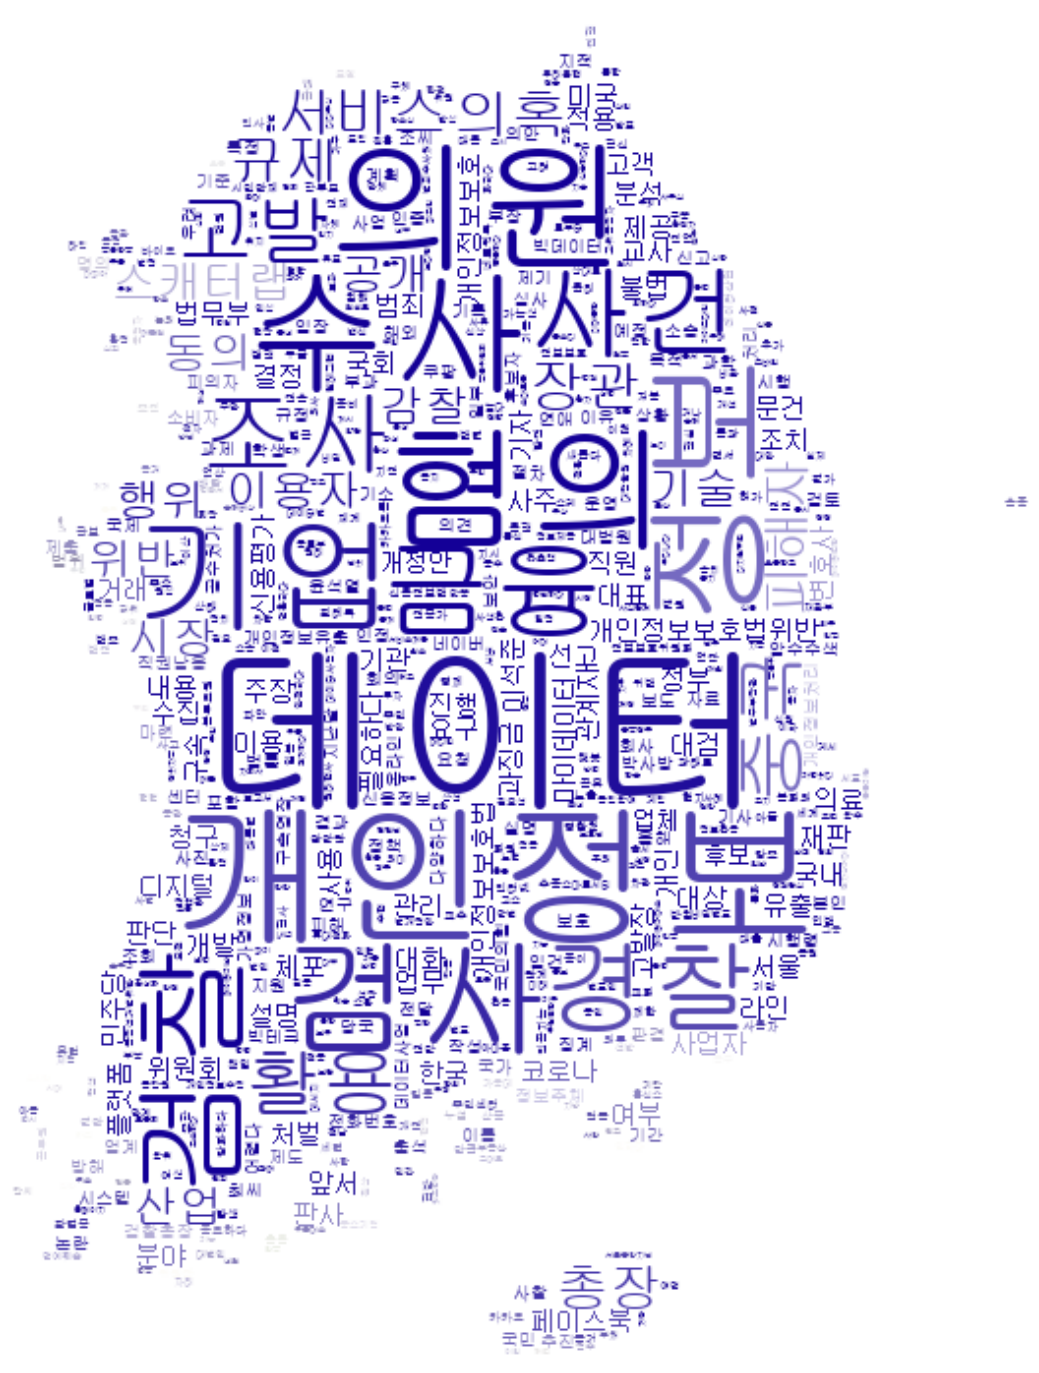

In [20]:
# Importing word cloud
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from PIL import Image

## Creating a masked wordcloud using TD-IDF
fig, ax = plt.subplots(figsize=(25,25))
custom_mask = np.array(Image.open("korea3.jpg"))
w = WordCloud(font_path='C:\\Windows\\Fonts\\gulim.ttc',
              background_color = 'white',
              width=800,height=600,
              mask = custom_mask,
              mode='RGBA',
              max_words=2000).fit_words(topwords)
image_colors = ImageColorGenerator(custom_mask)
w.recolor(color_func = image_colors)
plt.imshow(w, interpolation="bilinear")
plt.axis("off")
plt.show()
fig.savefig('조선일보_TFIDF_Wordcloud.png', dpi=800)

### LDA

In [91]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 6), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 5), (19, 7), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 2), (31, 6), (32, 5), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 5), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 3), (47, 3), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 2), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 5), (70, 1), (71, 3), (72, 2), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 4), (79, 1), (80, 1), (81, 1), (82, 1)]]


In [92]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'mallet-2.0.8/bin/mallet'  # update this path
# mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
import os
os.environ.update({'MALLET_HOME':r'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/'})

mallet_path = 'C:/Users/onrik/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path


# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [93]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

[(0,
  [('데이터', 0.02465245597775718),
   ('기술', 0.017052826691380907),
   ('기업', 0.017052826691380907),
   ('서비스', 0.015013901760889712),
   ('페이스북', 0.014087117701575533),
   ('이용자', 0.013901760889712697),
   ('사용', 0.01241890639481001),
   ('라인', 0.012233549582947173),
   ('수집', 0.012233549582947173),
   ('시장', 0.010194624652455977)]),
 (1,
  [('개인정보', 0.060482556243886536),
   ('정보', 0.032605151613955004),
   ('개인정보보호법', 0.014020215194000651),
   ('조치', 0.012552983371372678),
   ('유출', 0.012552983371372678),
   ('공개', 0.012389957613302902),
   ('제공', 0.011900880339093577),
   ('동의', 0.011900880339093577),
   ('행위', 0.011574828822954027),
   ('규정', 0.011248777306814476)]),
 (2,
  [('데이터', 0.040660919540229885),
   ('금융', 0.02543103448275862),
   ('서비스', 0.014367816091954023),
   ('고객', 0.013936781609195403),
   ('정보', 0.01206896551724138),
   ('마이데이터', 0.01192528735632184),
   ('플랫폼', 0.010919540229885057),
   ('소비자', 0.010201149425287357),
   ('회사', 0.009626436781609196),
   ('다양하다'

In [94]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [95]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=2)

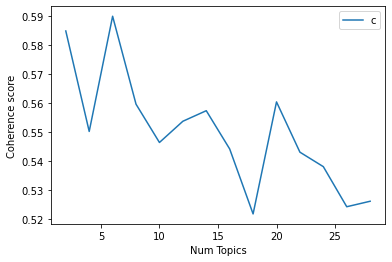

In [96]:
# Show graph
limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [97]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
model_list

Num Topics = 2  has Coherence Value of 0.5849
Num Topics = 4  has Coherence Value of 0.5502
Num Topics = 6  has Coherence Value of 0.59
Num Topics = 8  has Coherence Value of 0.5596
Num Topics = 10  has Coherence Value of 0.5464
Num Topics = 12  has Coherence Value of 0.5537
Num Topics = 14  has Coherence Value of 0.5574
Num Topics = 16  has Coherence Value of 0.5441
Num Topics = 18  has Coherence Value of 0.5217
Num Topics = 20  has Coherence Value of 0.5604
Num Topics = 22  has Coherence Value of 0.543
Num Topics = 24  has Coherence Value of 0.538
Num Topics = 26  has Coherence Value of 0.5242
Num Topics = 28  has Coherence Value of 0.5261


In [98]:
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=21))

[(0,
  '0.026*"의원" + 0.025*"수사" + 0.024*"검사" + 0.019*"검찰" + 0.019*"사건" + 0.015*"의혹" '
  '+ 0.014*"고발" + 0.014*"혐의" + 0.014*"조사" + 0.009*"총장" + 0.009*"감찰" + '
  '0.008*"대검" + 0.008*"청구" + 0.008*"판사" + 0.008*"국회" + 0.008*"개인정보보호법위반" + '
  '0.008*"체포" + 0.007*"법무부" + 0.007*"민주당" + 0.006*"사주"'),
 (1,
  '0.027*"데이터" + 0.017*"기술" + 0.015*"기업" + 0.011*"수집" + 0.011*"분석" + '
  '0.011*"대표" + 0.010*"의료" + 0.009*"사용" + 0.009*"개발" + 0.009*"보안" + 0.008*"활용" '
  '+ 0.008*"기반" + 0.007*"시장" + 0.007*"사업" + 0.006*"서비스" + 0.006*"코로나" + '
  '0.006*"선수" + 0.006*"핵심" + 0.006*"정보" + 0.006*"스마트시티"'),
 (2,
  '0.021*"혐의" + 0.018*"경찰" + 0.013*"장관" + 0.011*"처벌" + 0.011*"범죄" + '
  '0.010*"피해자" + 0.009*"내용" + 0.008*"주장" + 0.008*"행위" + 0.008*"위반" + '
  '0.008*"불법" + 0.007*"직원" + 0.007*"공개" + 0.007*"개인정보보호법위반" + 0.007*"교사" + '
  '0.007*"인정" + 0.007*"변호사" + 0.006*"사건" + 0.006*"선고" + 0.006*"이석준"'),
 (3,
  '0.032*"데이터" + 0.024*"금융" + 0.016*"활용" + 0.011*"고객" + 0.011*"신용평가" + '
  '0.010*"서비스" + 0.009*"마이데이터" + 0.009*"개인" +

In [99]:
ldadf = []
for i in range(len(optimal_model.print_topics(num_words= 20))):
    topic = optimal_model.print_topics(num_words= 20)[i]
    topic_num = 'topic' + ' ' + str(i+1)
    for j in range(len(topic[1].split(" + "))):
        term = topic[1].split(" + ")[j].split("*")[1][1:-1]
        ldanum = topic[1].split(" + ")[j].split("*")[0]
        ldadf.append({"topic": topic_num, 'term':term, 'lda_num':ldanum})
ldadf = pd.DataFrame(ldadf)
print(len(ldadf), ldadf.term.nunique())
ldadf

120 106


,topic,term,lda_num
0,topic 1,의원,0.026
1,topic 1,수사,0.025
2,topic 1,검사,0.024
3,topic 1,검찰,0.019
4,topic 1,사건,0.019
...,...,...,...
115,topic 6,미국,0.006
116,topic 6,정책,0.006
117,topic 6,과제,0.006
118,topic 6,요구,0.006


In [100]:
# Visualize the topics
# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

AttributeError: 'LdaMallet' object has no attribute 'inference'

In [101]:
ldadf.to_excel("조선일보 LDAdf_final2.xlsx", index=False)

In [102]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.4661,"혐의, 경찰, 장관, 처벌, 범죄, 피해자, 내용, 주장, 행위, 위반",경찰이 변호사법 위반 등 혐의로 고발된 온라인 법률상담 플랫폼 ‘로톡’ 운영사를 불...
1,1,1.0,0.4315,"데이터, 기술, 기업, 수집, 분석, 대표, 의료, 사용, 개발, 보안","미국의 빅데이터 분석 회사와 지역 교회들이 협업해 신도 모집, 봉사활동 전략을 세우..."
2,2,1.0,0.4893,"데이터, 기술, 기업, 수집, 분석, 대표, 의료, 사용, 개발, 보안",가구원수에 따라 배달앱 사용이 많은 지역이 다른 것으로 나타났다. 1인가구의 배달앱...
3,3,1.0,0.5338,"데이터, 기술, 기업, 수집, 분석, 대표, 의료, 사용, 개발, 보안",중소벤처기업부는 2019년 1차 특구 지정 후 총 29개 규제자유특구를 지정하고 일...
4,4,5.0,0.3997,"규제, 기업, 산업, 정부, 개인정보보호, 한국, 중국, 지원, 추진, 마련",중국 당국이 빅테크 규제를 강화하면서 지난 3년간 중국 앱 시장 규모가 40% 가까...
5,5,2.0,0.4809,"혐의, 경찰, 장관, 처벌, 범죄, 피해자, 내용, 주장, 행위, 위반",[승재현의 형사판] 형사법 전문가 승재현 한국형사법무정책연구원 박사와 함께하는 사건...
6,6,5.0,0.4653,"규제, 기업, 산업, 정부, 개인정보보호, 한국, 중국, 지원, 추진, 마련",문재인 대통령은 17일 유럽연합(EU)이 한국의 개인정보보호 체계가 EU의 관련 법...
7,7,2.0,0.7269,"혐의, 경찰, 장관, 처벌, 범죄, 피해자, 내용, 주장, 행위, 위반","경찰의 신변보호를 받던 전 여자친구의 가족을 살해한 이석준(25) 사건과 관련해, ..."
8,8,2.0,0.4899,"혐의, 경찰, 장관, 처벌, 범죄, 피해자, 내용, 주장, 행위, 위반",신변 보호를 받고 있는 전 연인의 집을 찾아가 어머니와 동생에게 흉기를 휘두른 혐의...
9,9,4.0,0.4764,"개인정보, 정보, 동의, 조치, 유출, 페이스북, 이용자, 제공, 규정, 개인정보보호법",미 애플은 지난 13일(현지 시각)부터 전 세계 아이폰 운영체제 업데이트를 통해 아...


In [103]:
df_dominant_topic.to_excel("조선일보_토픽별docu.xlsx",index=False)

### NER

In [26]:
import spacy
from spacy import displacy
import en_core_web_sm

nlp = en_core_web_sm.load()
def NER(lst):
    doc = nlp(lst)
    NERlst = []
    for X in doc.ents:
    #     NERlst.append((X.text, X.label_))
        if X.label_ == 'ORG':
            NERlst.append(X.text)

    return NERlst
qq =  df

qq['content'] = data_words_nostops
nlpdf = qq[['content']]
de_doc = []
for i in range(len(data_words_nostops)):
    t = ' '.join(data_words_nostops[i])
    de_doc.append(t)
qq['content'] = de_doc
nlpdf = qq[['content']]    
nlpdf['NER result'] = nlpdf['content'].apply(lambda x: NER(x))
nlpdf

<ipython-input-26-939e1312cae3>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlpdf['NER result'] = nlpdf['content'].apply(lambda x: NER(x))


,content,NER result
0,france threatened fine facial recognition comp...,"[cnil, american company, european unions, euro..."
1,views opinions expressed article author one co...,"[healthcare, eu health data space, eu health d..."
2,digital technologies transforming way work rap...,"[amazon, harvard business review]"
3,whatsapp rewritten privacy policy european use...,"[detail meta, european union, meta whatsapp, i..."
4,receiving film recommendation favourite video ...,"[edri, netherlands finland commission, axel, e..."
...,...,...
58,eu citizens tracked ad tech companies visit go...,"[eu government, eu, eu citizens]"
59,office thats responsible enforcing european da...,"[ireland data protection commission, federal t..."
60,northern ireland backstop continuing thorn the...,"[congress, un, un, congress, microsoft]"
61,frances regulatory body dealing data privacy f...,"[national commission, eu major new data]"


In [27]:
from nltk.probability import FreqDist
NERll = nlpdf['NER result'].sum()
fdist = FreqDist(NERll)
top_20 = fdist.most_common(20)
top_20

[('european commission', 40),
 ('european union', 27),
 ('congress', 5),
 ('irelands data protection commission', 3),
 ('eu data protection', 3),
 ('european data protection board', 3),
 ('airbus', 3),
 ('wto', 3),
 ('ireland data protection commission', 3),
 ('kremlin', 3),
 ('eu health data space', 2),
 ('amazon', 2),
 ('data protection commission', 2),
 ('max', 2),
 ('eu court', 2),
 ('irish data protection commission', 2),
 ('von der leyen', 2),
 ('android', 2),
 ('eu general data protection', 2),
 ('general data protection', 2)]